# Spinal cord injury analysis

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Dataset

The data comes from the National Spinal Cord Injury Statistical Center (NSCISC).

Unpack it a `data` directory as follows for scripts to find it:
```
data
├── f1_public_2021.csv
└── f2_public_2021.csv
```

The two files contain responses to two forms, f1 and f2. The first form is administered at injury time. The second is recurring, first one year after the injury, then five, then every five years after this.

The vast majority of columns are categories whose definitions are given in a data dictionary, but we keep them as strings and integers for now to facilitate computations. The columns explicitely listed below contain a mix of integers and strings (e.g. `32` and `"6-12y"`) so we import them as strings to avoid warnings.

In [2]:
df1 = pd.read_csv(
    "data/f1_public_2021.csv",
    dtype={col_name: str for col_name in ['AExtCsIj', 'AASAImAd', 'AASAImDs', 'AInjAge']},
)
df2 = pd.read_csv(
    "data/f2_public_2021.csv",
    dtype={col_index: str for col_index in ['BASAImp']},
)

The two forms have a single column in common, a unique ID per patient called `UniID`, so we can merge them into a single long-form dataframe.

In [3]:
df = pd.merge(df2, df1, on='UniID', how='left')

## Research questions

We'd like to answer the following questions:

1. Do people with high functional scores still report low engagement in leisure or screen-based activities?
2. Do higher depression scores correlate with lower leisure/screen engagement?
3. Are younger people more likely to engage in screen-based leisure?
4. Do mobility users report lower participation?
5. Is lower income associated with reduced leisure and higher depression?

To do that, we have to identify the relevant columns and compute some aggregated scores. Let's start with functional scores.

In [4]:
functional_columns = {
    'ACrEat': 'Self-Care A. Eating',
    'ACrOrl': 'Self-Care B. Oral Hygiene',
    'ACrTlHy': 'Self-Care C. Toileting hygiene',
    'ACrShr': 'Self-Care E. Shower/bathe self',
    'ACrUpDr': 'Self-Care F. Upper body dressing',
    'ACrLrDr': 'Self-Care G. Lower body dressing',
    'ACrFtr': 'Self-Care H. Putting on/taking off footwear',
    'ACrRll': 'Mobility A. Roll left to right',
    'ACrStLy': 'Mobility B. Sitting to lying',
    'ACrLySt': 'Mobility C. Lying to sitting on side of bed',
    'ACrStSd': 'Mobility D. Sit to stand',
    'ACrChrT': 'Mobility E. Chair/bed-to-chair transfer',
    'ACrTltT': 'Mobility F. Toilet transfer',
    'ACrCar': 'Mobility G. Car transfer',
    'ACrWa10': 'Walk I. Walk 10 feet',
    'ACrW502': 'Walk J. Walk 50 feet with 2 turns',
    'ACrW150': 'Walk K. Walk 150 feet',
    'ACrWaUn': 'Walk L. Walk 10 feet on uneven surface',
    'ACr1Stp': 'Walk M. 1 step (curb)',
    'ACr4Stp': 'Walk N. 4 steps',
    'ACr12St': 'Walk O. 12 steps',
    'ACrPiUp': 'Walk P. Picking up object',
    'ACrCh50': 'Wheel R. Wheel 50 feet with 2 turns',
    'ACrC150': 'Wheel S. Wheel 150 feet',
}

All these columns correspond to functional scores and share the same response category.

In [5]:
functional_category = {
  1: 'Dependent',
  2: 'Substantial/maximal assistance',
  3: 'Partial/moderate assistance',
  4: 'Supervision or Touching Assistance',
  5: 'Setup or clean-up assistance',
  6: 'Independent',
  7: 'Patient Refused',
  9: 'Not applicable',
  10: 'Not attempted due to environmental limitations',
  88: 'Not attempted due to medical condition or safety concerns',
  99: 'Unknown, No rehab admit',
}

Note that we exclude:
- `ACrCh`: Wheel Q. Does patient use wheelchair/scooter
- `ACrT50`: Wheel RR Type of wheelchair/scooter used
- `ACrT150`: Wheel SS 150 Ft Type of wheelchair/scooter used

even though they are functional responses because they use a different category (yes/no).

Also note that each column actually maps to two columns because the same questions get evaluated twice, once at the start of rehab and once at discharge. They're differentiated by the suffixes `R` and `D`.

In [6]:
functional_columns = [f'{key}{suffix}' for key in functional_columns.keys() for suffix in ['R', 'D']]

Next we can compute the average functional score. Since it's only using data from form 1, we prefix the new column with `A` for consistency.

In [7]:
df1['AFunctionalScore'] = df1[functional_columns][df1[functional_columns] < 7].dropna(how='all', axis=0).mean(axis=1)

Let's add that new colum to `df`.

In [8]:
df = pd.merge(df, df1[['UniID', 'AFunctionalScore']], on='UniID', how='left')

For depression, we can use pre-calculated columns. `ABPHQMDS` (PHQ-9 Major Depressive Syndrome) is a three-level scale (major/other/none) that gets calculated based on specific criteria. `ABPHQSDS` (PHQ-Severity of Depression) is the sum of responses to individual screening questions so is more granular (0 to 27) but does not map to a specific diagnostic. We'll stick with `ABPHQMDS` for now.

In [9]:
depression_columns = ['ABPHQMDS']

In [10]:
depression_category = {
    0: 'No depressive syndrome',
    1: 'Major depressive syndrome',
    2: 'Other depressive syndrome',
    7: 'Declined',
    9: 'Unknown, interview not done, age <18',
}

Even if it's a single column, let's create a new column excluding invalid entries.

In [11]:
df1['ADepressionScore'] = df1[depression_columns][df1[depression_columns] < 3].dropna(how='all', axis=0)
df = pd.merge(df, df1[['UniID', 'ADepressionScore']], on='UniID', how='left')

For form 1, the age at time of injury is provided. For form 2, the age is calculated by summing the age at time of injury with the years since the injury happened. But since ages for minors and seniors are reported as age group strings like `6-12y` or `88+`, we have to add years since the injury to individual numbers within each string.

In [12]:
def add(text, num):
    return re.sub(r'\d+', lambda match: str(int(match.group(0)) + num), text)

It's important to use the correct age column depending on the form. Thankfully column names are prefixed with `A` or `B` depending on the form, so we use that same convention to compute the age for form 2.

In [13]:
df['BAge'] = df.apply(lambda row: add(row['AInjAge'], row['BYear']), axis=1)

Mobility questions are a subset of functional questions.

In [14]:
mobility_columns = {
    'ACrRll': 'Mobility A. Roll left to right',
    'ACrStLy': 'Mobility B. Sitting to lying',
    'ACrLySt': 'Mobility C. Lying to sitting on side of bed',
    'ACrStSd': 'Mobility D. Sit to stand',
    'ACrChrT': 'Mobility E. Chair/bed-to-chair transfer',
    'ACrTltT': 'Mobility F. Toilet transfer',
    'ACrCar': 'Mobility G. Car transfer',
    'ACrWa10': 'Walk I. Walk 10 feet',
    'ACrW502': 'Walk J. Walk 50 feet with 2 turns',
    'ACrW150': 'Walk K. Walk 150 feet',
    'ACrWaUn': 'Walk L. Walk 10 feet on uneven surface',
    'ACr1Stp': 'Walk M. 1 step (curb)',
    'ACr4Stp': 'Walk N. 4 steps',
    'ACr12St': 'Walk O. 12 steps',
    'ACrPiUp': 'Walk P. Picking up object',
    'ACrCh50': 'Wheel R. Wheel 50 feet with 2 turns',
    'ACrC150': 'Wheel S. Wheel 150 feet',
}
mobility_columns = [f'{key}{suffix}' for key in mobility_columns.keys() for suffix in ['R', 'D']]

In [15]:
df1['AMobilityScore'] = df1[mobility_columns][df1[mobility_columns] < 7].dropna(how='all', axis=0).mean(axis=1)
df = pd.merge(df, df1[['UniID', 'AMobilityScore']], on='UniID', how='left')

Income is readily available in both forms, as a category.

In [16]:
income_columns = ['AFmIncLv', 'BFmIncLv']

In [17]:
income_category = {
    1: '< $25,000',
    2: '$25,000 - $49,999',
    3: '$50,000 - $74,999',
    4: '$75,000 plus',
    6: 'Participant doesn’t know',
    7: 'Declined',
    9: 'Unknown/Interview not done',
}

In [18]:
df[['AIncome', 'BIncome']] = df[income_columns][df[income_columns] < 6].dropna(how='all', axis=0)

Leisure and screen-based activities are central to the research questions we're trying to answer yet there is very little relevant corresponding data. We have to content ourselves with indirect answers like _I found new things to enjoy_ or _Internet or Email Usage, how often_.

In [19]:
leisure_columns = ['ARsNewTh']

In [20]:
screen_based_activities_columns = ['BInetEml']

Unfortunately, those columns don't figure in the data dictionary so we don't know for sure what categories they use. However, we can guess their range and still compute a score.

In [21]:
leisure_category = {
    1: 'Not at all',
    2: 'A little bit',
    3: 'Somewhat',
    4: 'Quite a bit',
    5: 'Very much',
    7: 'Declined',
    9: 'Unknown, Interview not done, age < 18',
}

In [22]:
screen_based_activities_category = {
    0: 'Never',
    1: 'Rarely',
    2: 'Often',
    3: 'All the time',
    8: 'Declined',
    9: 'Unknown, Interview not done, age < 18',
}

Let's add columns for them too.

In [23]:
df1['ALeisureScore'] = df1[leisure_columns][df1[leisure_columns] < 6].dropna(how='all', axis=0)
df = pd.merge(df, df1[['UniID', 'ALeisureScore']], on='UniID', how='left')

In [24]:
df['BScreenScore'] = df[screen_based_activities_columns][df[screen_based_activities_columns] < 4].dropna(how='all', axis=0)

Lastly, we need to measure participation. I interpret this to mean participation in social activities, rather than participation to the survey which would be hard to measure. We'll use the _social integration_ computed column `BCHSocIn` which is a score between 0 and 100.

In [25]:
participation_columns = ['BCHSocIn']

In [26]:
df['BParticipationScore'] = df[participation_columns][df[participation_columns] < 101].dropna(how='all', axis=0)

## Question 1

> Do people with high functional scores still report low engagement in leisure or screen-based activities?

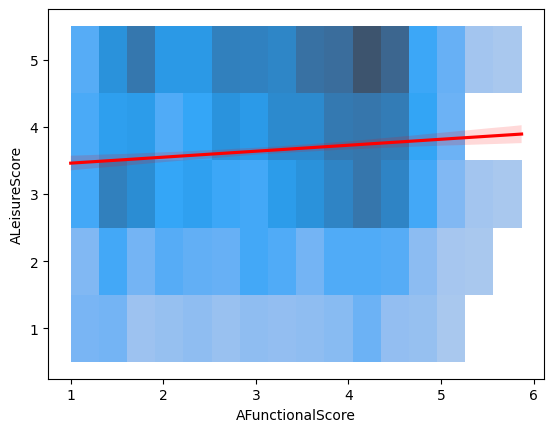

In [27]:
sns.histplot(df, x='AFunctionalScore', y='ALeisureScore', discrete=(False, True))
sns.regplot(df, x='AFunctionalScore', y='ALeisureScore', marker='', line_kws={'color':'r'})
plt.show()

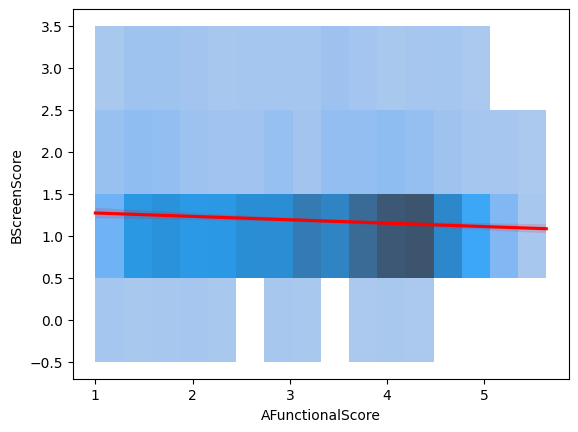

In [28]:
sns.histplot(df, x='AFunctionalScore', y='BScreenScore', discrete=(False, True))
sns.regplot(df, x='AFunctionalScore', y='BScreenScore', marker='', line_kws={'color':'r'})
plt.show()

# Question 2

> Do higher depression scores correlate with lower leisure/screen engagement?

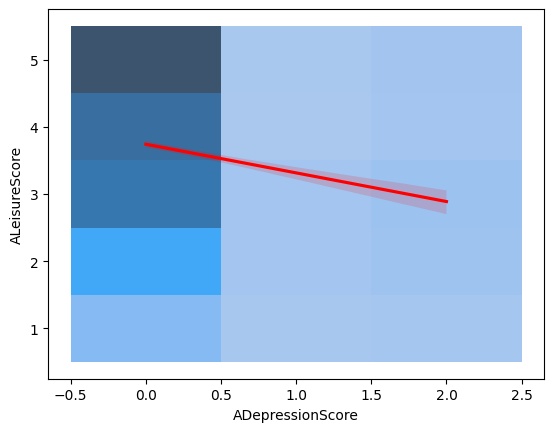

In [29]:
sns.histplot(df, x='ADepressionScore', y='ALeisureScore', discrete=(True, True))
sns.regplot(df, x='ADepressionScore', y='ALeisureScore', marker='', line_kws={'color':'r'})
plt.show()

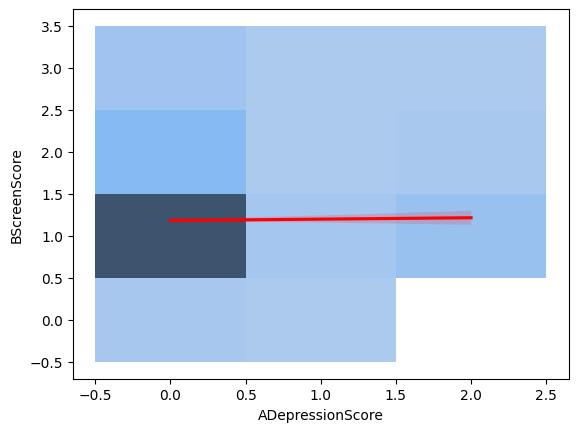

In [30]:
sns.histplot(df, x='ADepressionScore', y='BScreenScore', discrete=(True, True))
sns.regplot(df, x='ADepressionScore', y='BScreenScore', marker='', line_kws={'color':'r'})
plt.show()

# Question 3

> Are younger people more likely to engage in screen-based leisure?

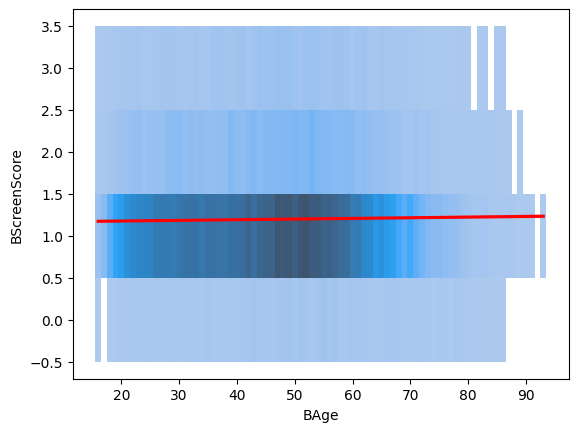

In [31]:
sub = df[df['BAge'].str.isnumeric()].copy()
sub['BAge'] = sub['BAge'].astype(int)
sns.histplot(sub, x='BAge', y='BScreenScore', discrete=(True, True))
sns.regplot(sub, x='BAge', y='BScreenScore', marker='', line_kws={'color':'r'})
plt.show()

# Question 4

> Do mobility users report lower participation?

Note: not sure if _mobility user_ means something specific or if the question is just missing a word (_low_).

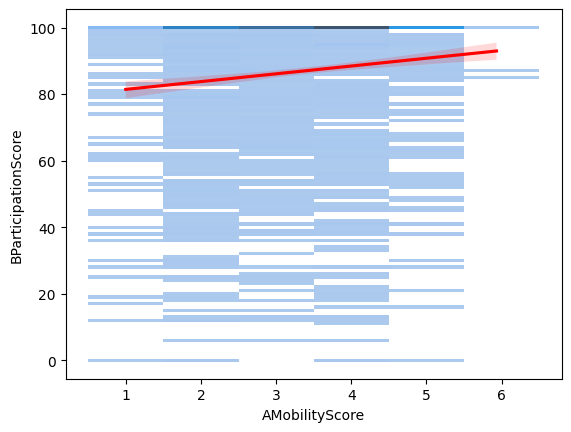

In [32]:
sns.histplot(df, x='AMobilityScore', y='BParticipationScore', discrete=(True, True))
sns.regplot(df, x='AMobilityScore', y='BParticipationScore', marker='', line_kws={'color':'r'})
plt.show()

# Question 5

> Is lower income associated with reduced leisure and higher depression?

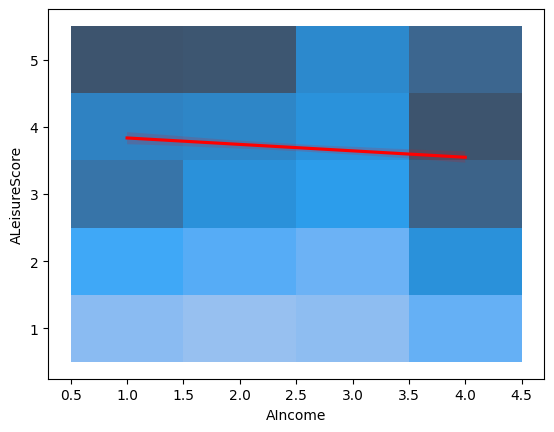

In [33]:
sns.histplot(df, x='AIncome', y='ALeisureScore', discrete=(True, True))
sns.regplot(df, x='AIncome', y='ALeisureScore', marker='', line_kws={'color':'r'})
plt.show()

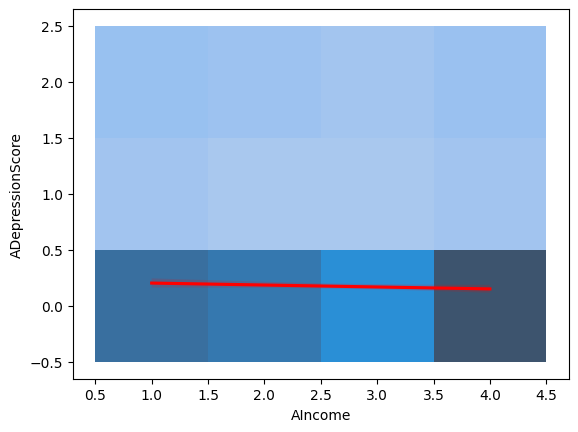

In [34]:
sns.histplot(df, x='AIncome', y='ADepressionScore', discrete=(True, True))
sns.regplot(df, x='AIncome', y='ADepressionScore', marker='', line_kws={'color':'r'})
plt.show()